**More stuff:**
* demonstrate each kernel
* missing data -> replace by central tendency/c.t.+random var
* bin continuous data <- use exploratory statistics
* sklearns polynomial feature generation
* warn that $C\equiv 1/\alpha$: low C -> smooth boundary, high C -> sqiggly boundary.
* RBF: large gamma -> "influence" decays faster with distance.

### Story:
* LR draws a limited decision boundary.
* Generalization: nonlinear d.b. via feature engineering `http://scikit-learn.org/stable/modules/preprocessing.html`
* Alternative: SVM.
* The math. 
  - How high $C$ punishes misclassification.
    + Demonstrate with [d.b. vidualization](http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html). 
* Nonlinear Kernels:
  - `rbf` kernel: "effective distance".
  - `poly` kernel.
  - Demonstrate above two with d.b. vidualization. 
  
  
  ### Links
  * https://en.wikipedia.org/wiki/Support_vector_machine
  * https://en.wikipedia.org/wiki/Kernel_method
  * https://en.wikipedia.org/wiki/Radial_basis_function_kernel
  * http://scikit-learn.org/stable/modules/svm.html#svc
 




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
%matplotlib inline
import matplotlib
sns.set_style('whitegrid')
matplotlib.rcParams['figure.figsize'] = (10,8)
matplotlib.rcParams['font.size']=20
matplotlib.rcParams['lines.linewidth']=4
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.width'] = 2

## Support Vector Machines (SVM)

In [2]:
def _random_pt_in_circle(center, radius, num):
    angle = np.random.uniform(0, 2*np.pi, num)
    r = np.random.uniform(0,radius, num)
    return (r*np.vstack((np.cos(angle), np.sin(angle)))).T + center

In [3]:
m = 1
halfsep = 0.3

np.random.seed(2)

N = 100
x = np.random.uniform(-1,1, size=N)


y_cl1 = m*x + np.random.uniform(0,10, size=N) + halfsep
y_cl2 = m*x - np.random.uniform(0,10, size=N) - halfsep

# two misclassified points in upper cluster
idx_to_lower = np.random.randint(0, y_cl1.size, size=2)
y_cl1[idx_to_lower] = m*x[idx_to_lower] - np.random.uniform(0.6*halfsep,0.8*halfsep, size=2) + halfsep

# two misclassified points in lower cluster
idx_to_upper = np.random.randint(0, y_cl2.size, size=2)
y_cl2[idx_to_upper] = m*x[idx_to_upper] + np.random.uniform(0.6*halfsep,0.8*halfsep, size=2) - halfsep

cl1 = np.vstack((x, y_cl1)).T
cl2 = np.vstack((x, y_cl2)).T

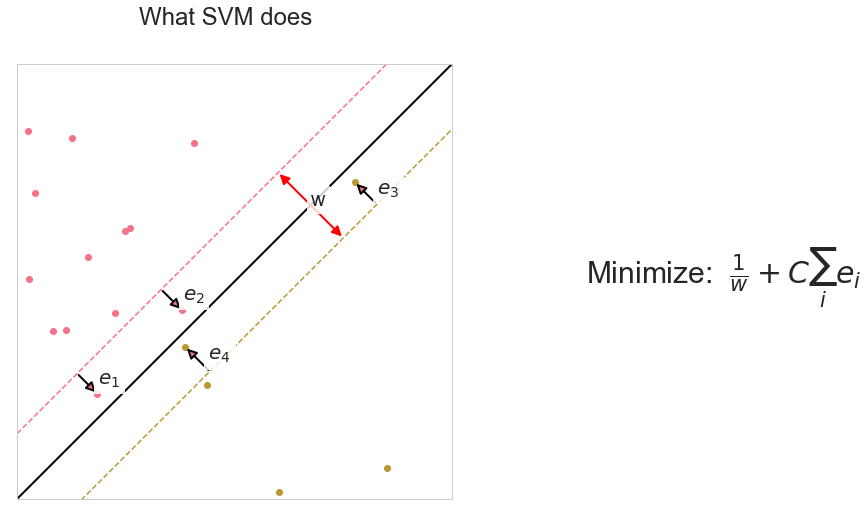

In [4]:
fig, ax = plt.subplots()

ax.set_aspect('equal')
ax.set_prop_cycle(None)
ax.scatter(cl1[:,0], cl1[:,1])
ax.scatter(cl2[:,0], cl2[:,1])


text_bbox_dict = dict(facecolor='white', alpha=0.8, ec='white')

all_x = np.linspace(-1,1,10)

ax.set_prop_cycle(None)
ax.plot(all_x, m*all_x + halfsep, '--', lw=1.5)
ax.plot(all_x, m*all_x - halfsep,  '--', lw=1.5)
ax.plot(all_x, m*all_x, c='black', lw=2)

x1 = 0.5
y_u = m*x1 + halfsep
y_l = m*x1 - halfsep

dx = halfsep
ax.annotate("", xy=(x1, y_l), xytext=(x1-dx,y_l+dx), arrowprops=dict(arrowstyle="<|-|>", ec='red', fc='red', mutation_scale=20, lw=2))
#ax.arrow(x1, y_l, -dx, dx, width=0.01, shape='full', ec='red', fc='red')
ax.text(x1-dx/2, y_l+dx/2, 'w', bbox=text_bbox_dict)

pts_beyond_upper = cl1[cl1[:,1]<m*cl1[:,0]+halfsep,:]
pts_beyond_lower = cl2[cl2[:,1]>m*cl2[:,0]-halfsep,:]

text_eps = 0.05

errnum = 0
for u,v in pts_beyond_upper:
    errnum += 1
    perpfoot = (u+v-halfsep)/2, (u+v+halfsep)/2
    ax.annotate("", xy=(u,v), xytext=perpfoot, arrowprops=dict(arrowstyle="-|>", lw=2))
    ax.text((u+perpfoot[0])/2+text_eps, (v+perpfoot[1])/2, r'$e_{%d}$'%errnum, bbox=text_bbox_dict)

for u,v in pts_beyond_lower:
    errnum += 1
    perpfoot = (u+v+halfsep)/2, (u+v-halfsep)/2
    ax.annotate("", xy=(u,v), xytext=perpfoot, arrowprops=dict(arrowstyle="-|>", lw=2))
    ax.text((u+perpfoot[0])/2+text_eps, (v+perpfoot[1])/2, r'$e_{%d}$'%errnum, bbox=text_bbox_dict)
    
# aesthetics
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xticks([])
ax.set_yticks([])


ax2 = fig.add_axes([1, 0.5, 0.1,0.1])
ax2.text(0,0, r"Minimize:  $\frac{1}{w}+C\sum_i e_i$", fontsize=30)

ax2.axis('off')
fig.suptitle('What SVM does')

fig.savefig('svm-schematics.svg')

**Low** $C\Rightarrow$ decision planes **farther apart**.

**High** $C\Rightarrow$ decision planes more **squiggly**.  

**Power of SVM: nonlinear decision planes**
![title](images/svm-schematics.svg)

## See in an (artificial) example

In [5]:
# create artificial features and labels
n_sample = 100
features = np.random.uniform(low=-1, high=1, size=(n_sample, 2))

labels = features[:,1]*features[:,1] + features[:,0]*features[:,0] - 0.9
#labels -= labels.mean()
labels = np.where(labels+np.random.randn(*labels.shape)*0.3 > 0, 1, 0)

df = pd.DataFrame(features, columns = ['a', 'b'])
df.loc[:, 'label'] = labels

df.head()

,a,b,label
0,-0.747680,-0.497434,0
1,0.762471,0.806592,1
2,-0.424729,0.934226,1
3,0.336199,0.006014,0
4,-0.243995,-0.325263,0


In [6]:
## make each class of equal size

min_size = min(df[df['label']==1].shape[0], df[df['label']==0].shape[0])
class1 = df[df['label']==1].sample(min_size)
class2 = df[df['label']==0].sample(min_size)

df = pd.concat((class1, class2))

/home/dmanik/projects/mpi/pyd3t/.devenv34/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/home/dmanik/projects/mpi/pyd3t/.devenv34/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


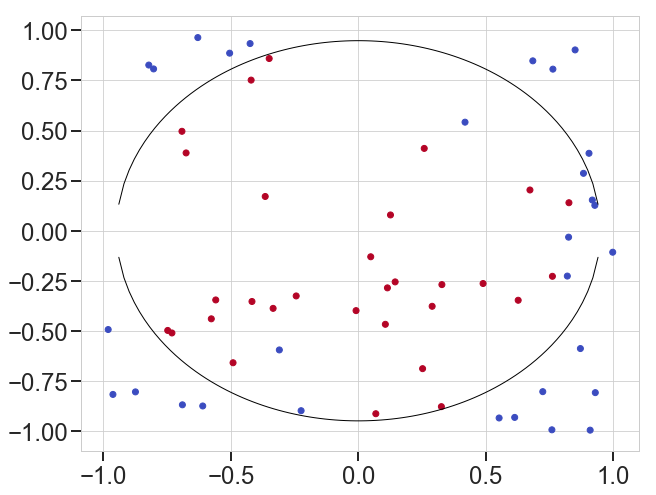

In [7]:
fig, ax = plt.subplots()

ax.scatter(x=df.loc[:, 'a'], y=df.loc[:, 'b'], c=df.loc[:, 'label'], cmap=plt.cm.coolwarm_r)

x_dummy = np.linspace(-1,1,100)
ax.plot(x_dummy, np.sqrt(0.9-x_dummy**2), c='k', lw=1)
ax.plot(x_dummy, -np.sqrt(0.9-x_dummy**2), c='k', lw=1)

**Unsurprisingly, logistic regression doesn't work well**

In [8]:
from sklearn.model_selection import train_test_split
training_data, test_data, training_labels, test_labels = train_test_split(features, labels, train_size=0.5)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data: IMPORTANT
scaler.fit(training_data)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [9]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(scaler.transform(training_data), training_labels)
lr.score(scaler.transform(test_data), test_labels)

0.64000000000000001

* Solution 1: use feature engineering with logistic regression.
* Solution 2: SVM with `poly` kernel.

In [10]:
from sklearn.svm import SVC

In [11]:
clf = SVC(kernel='poly', degree=4, C=1, coef0=0.9)
clf.fit(scaler.transform(training_data), training_labels)
clf.score(scaler.transform(test_data), test_labels)

0.85999999999999999

### plot decision function

In [12]:
# source: http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contour(xx, yy, Z, **params)
    return out

(-2.5026954025590715, 2.9573045974409329)

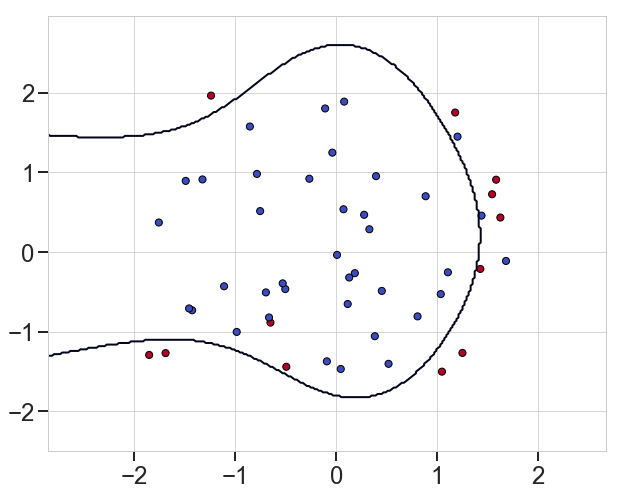

In [13]:
training_data_scaled = scaler.transform(training_data)


X0, X1 = training_data_scaled[:, 0], training_data_scaled[:, 1]
xx, yy = make_meshgrid(X0, X1)

fig, ax = plt.subplots()
plot_contours(ax, clf, xx, yy, levels=[0], linewidths=2)

ax.scatter(X0, X1, c=training_labels, cmap=plt.cm.coolwarm, s=50, edgecolors='k')

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())

### Using `GridSearchCV` for tuning SVM

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
svr = SVC()
clf = GridSearchCV(svr, {'C':[0.1,1,10], 'coef0': np.linspace(-1,1,10), 'kernel': ['poly'], 'degree':[2,3,4]})

In [16]:
clf.fit(scaler.transform(training_data), training_labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'degree': [2, 3, 4], 'C': [0.1, 1, 10], 'kernel': ['poly'], 'coef0': array([-1.     , -0.77778, -0.55556, -0.33333, -0.11111,  0.11111,
        0.33333,  0.55556,  0.77778,  1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [17]:
clf.best_params_

{'C': 1, 'coef0': 0.11111111111111116, 'degree': 4, 'kernel': 'poly'}

In [19]:
svm_tuned = clf.best_estimator_

In [20]:
svm_tuned.fit(scaler.transform(training_data), training_labels)
svm_tuned.score(scaler.transform(test_data), test_labels)

0.83999999999999997

### How $C$ affects the decision boundary

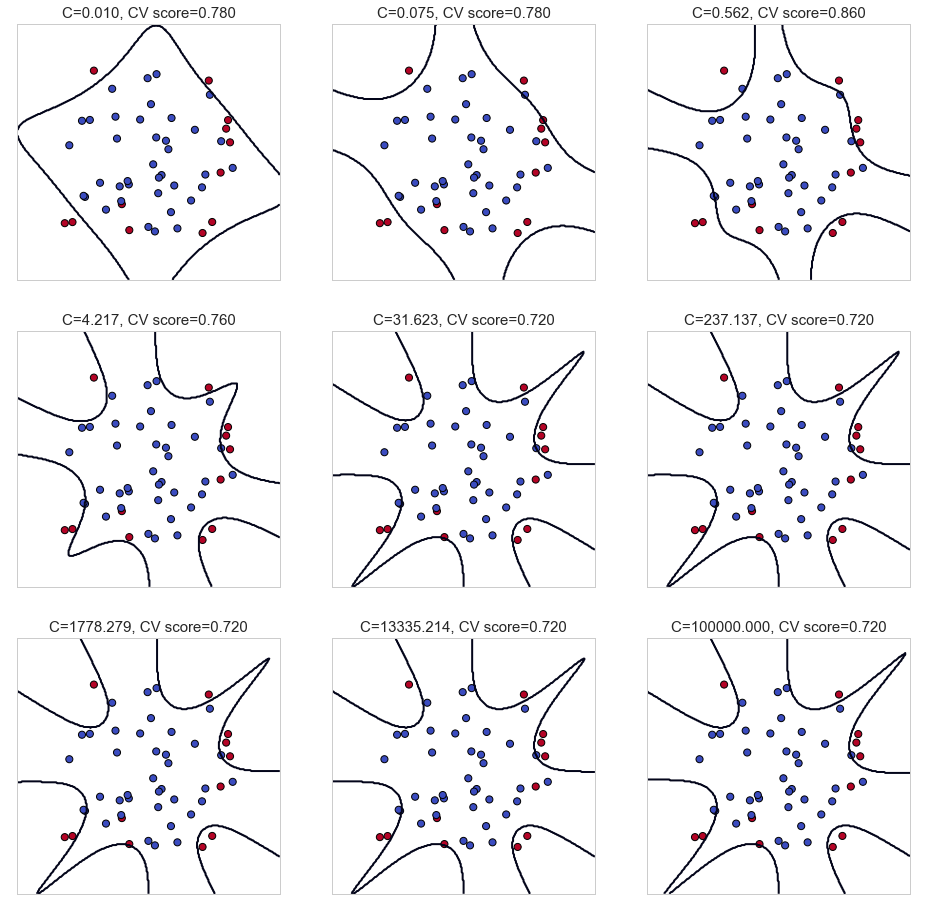

In [22]:
C_arr = np.logspace(-2, 5,9)


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,16))
axes = axes.reshape(-1,)

training_data_scaled = scaler.transform(training_data)
X0, X1 = training_data_scaled[:, 0], training_data_scaled[:, 1]
xx, yy = make_meshgrid(X0, X1)

for idx, c in enumerate(C_arr):
    ax = axes[idx]
    clf = SVC(kernel='poly', degree=6, C=c)
    clf.fit(scaler.transform(training_data), training_labels)
    score = clf.score(scaler.transform(test_data), test_labels)
    
    
    plot_contours(ax, clf, xx, yy, levels=[0], linewidths=2)
    ax.scatter(X0, X1, c=training_labels, cmap=plt.cm.coolwarm, s=50, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    ax.set_title('C=%.3f, CV score=%.3f'%(c,score), fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])

## Titanic stuff

In [2]:
tdata = sns.load_dataset('titanic')

In [3]:
tdata.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


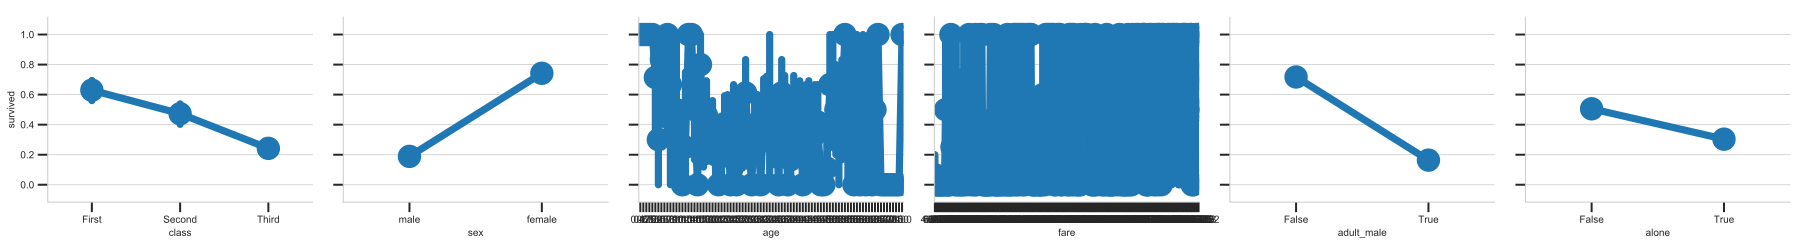

In [4]:
g = sns.PairGrid(tdata,
                 x_vars=['class', 'sex', 'age', 'fare', 'adult_male', 'alone'],
                 y_vars=["survived"],
                 aspect=1.2, size=3.5)
g.map(sns.pointplot, lw=0.2)

AttributeError: 'JointGrid' object has no attribute 'set_xticks'

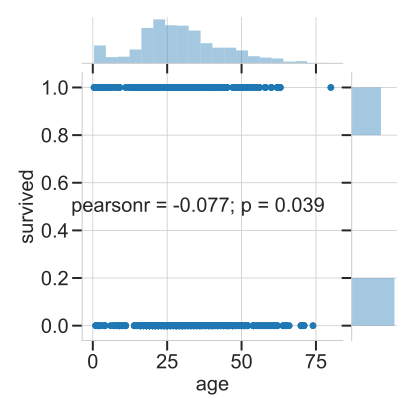

In [67]:
ax = sns.jointplot('age', 'survived', data=tdata)
ax.set_xticks(np.linspace(*ax.get_xlim(), 10))

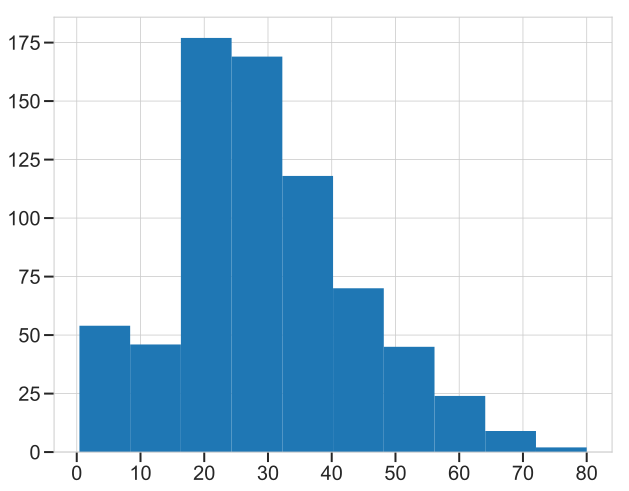

In [66]:
tdata['age'].hist()

In [5]:
features = tdata[['pclass', 'sex', 'age', 'fare', 'adult_male', 'alone']]
labels = tdata['survived']

## Create features and labels

In [6]:
feature_cols = ['pclass', 'sex', 'age', 'fare', 'adult_male', 'alone']
label_col = 'survived'

relevant_data = tdata[feature_cols+[label_col]]
relevant_data = relevant_data.dropna(how='any')

In [7]:
features = relevant_data[feature_cols]
labels = relevant_data[label_col]

In [8]:
features['sex'] = features['sex'].apply(lambda x:1 if x=='female' else 0)

/home/dmanik/venvs/teaching/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
features.head()

,pclass,sex,age,fare,adult_male,alone
0,3,0,22.0,7.2500,True,False
1,1,1,38.0,71.2833,False,False
2,3,1,26.0,7.9250,False,True
3,1,1,35.0,53.1000,False,False
4,3,0,35.0,8.0500,True,True


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
training_data, test_data, training_labels, test_labels = train_test_split(features, labels, train_size=0.5)

/home/dmanik/venvs/teaching/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data: IMPORTANT
scaler.fit(training_data)

StandardScaler(copy=True, with_mean=True, with_std=True)

## train svm

In [13]:
from sklearn.svm import SVC

In [14]:
clf = SVC()
clf.fit(scaler.transform(training_data), training_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
clf.score(scaler.transform(test_data), test_labels)

0.8179271708683473

In [16]:
np.logspace(-2,-4,5)

array([0.01      , 0.00316228, 0.001     , 0.00031623, 0.0001    ])

In [51]:
from sklearn.model_selection import GridSearchCV
svr = SVC()

#clf = GridSearchCV(svr, {'C':np.logspace(-4, 8, 6), 'gamma':np.logspace(-8,-4,4)}, n_jobs = -1)
clf = GridSearchCV(svr, {'kernel':['rbf'], 'C':np.logspace(-1, 4, 8), 'gamma':np.logspace(-1,-4,8)}, n_jobs = -1)

#tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                     'C': [1, 10, 100, 1000]},
#                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

#clf = GridSearchCV(svr, tuned_parameters)
#clf = GridSearchCV(svr, {'kernel':['poly'], 'C':np.logspace(-2, 10, 8), 'degree': [2,3,4], 'gamma':np.logspace(-2,-6,8)}, n_jobs = -1)

In [52]:
clf.fit(scaler.transform(training_data), training_labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'kernel': ['rbf'], 'gamma': array([0.1    , 0.03728, 0.01389, 0.00518, 0.00193, 0.00072, 0.00027,
       0.0001 ]), 'C': array([1.00000e-01, 5.17947e-01, 2.68270e+00, 1.38950e+01, 7.19686e+01,
       3.72759e+02, 1.93070e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [53]:
clf.best_params_

{'C': 1930.6977288832495, 'gamma': 0.0019306977288832496, 'kernel': 'rbf'}

In [54]:
np.logspace(-1, 6, 4)[0]

0.1

In [55]:
svm_tuned = clf.best_estimator_
svm_tuned.fit(scaler.transform(training_data), training_labels)

SVC(C=1930.6977288832495, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0019306977288832496,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [56]:
svm_tuned.score(scaler.transform(test_data), test_labels)

0.8095238095238095

In [57]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(scaler.transform(training_data), training_labels)
lr.score(scaler.transform(test_data), test_labels)

0.7871148459383753